In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

resolution = 10  #pixels/um

sx = 16
sy = 32          #size of cells in x, y directions respectively
cell = mp.Vector3(sx, sy, 0)

dpml = 1.0
pml_layers = [mp.PML(dpml)]

In [2]:
pad = 4 #padding between waveguide and cell edge
w = 1   #width of waveguide

In [7]:
wvg_xcen =  0.5 * (sx - w - 2 * pad)     #x centre of horizontal waveguide
wvg_ycen = -0.5 * (sy - w - 2 * pad)     #y centre of vertical waveguide

In [8]:
geometry = [
    mp.Block(
        size   = mp.Vector3(mp.inf, w, mp.inf),
        center = mp.Vector3(0, wvg_ycen, 0),
        material = mp.Medium(epsilon=12),
    )
]

In [10]:
fcen = 0.15   #pulse centre frequency
df   = 0.1    #pulse width (freqeuncy)

sources = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ez,
        center=mp.Vector3(-0.5 * sx + dpml, wvg_ycen, 0),
        size = mp.Vector3(0, w, 0),
    )
]

     block, center = (0,-11.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)


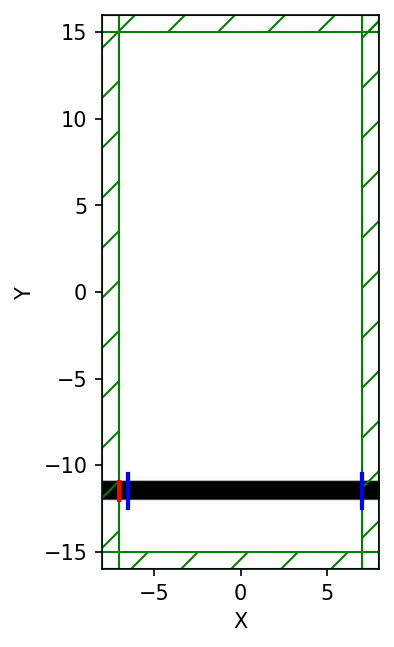

In [15]:
sim = mp.Simulation(
    cell_size = cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

nfreq = 100   #number of frequencies at which to compute flux

#reflected flux
refl_fr = mp.FluxRegion(
    center = mp.Vector3(-0.5 * sx + dpml + 0.5, wvg_ycen, 0), size = mp.Vector3(0, 2 * w, 0)
)
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

#transmitted
tran_fr = mp.FluxRegion(
    center=mp.Vector3(0.5 * sx - dpml, wvg_ycen, 0), size = mp.Vector3(0, 2 * w, 0)
)

tran = sim.add_flux(fcen, df, nfreq, tran_fr)

#i want to compute the fluxes through the line segment twice the width of the waveguide.

plt.figure(dpi=150)
sim.plot2D()
plt.show()



In [17]:
pt = mp.Vector3(0.5 * sx - dpml - 0.5, wvg_ycen)

sim.run(until_after_sources= mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-3))
#the stop_when_fields_decayed function essentially makes it so it keeps running for an additional 50 time units 
#until the square amplitude decays by 1/1000 from its peak. this is to ensure that the Fourier transforms converged

#save flux fields data for reflection plane
straight_refl_data = sim.get_flux_data(refl)

field decay(t = 100.05000000000001): 7.058050347675667e-05 / 7.058050347675667e-05 = 1.0
on time step 2001 (time=100.05), 0.0846884 s/step
field decay(t = 150.1): 0.026893465093385728 / 0.026893465093385728 = 1.0
field decay(t = 200.15): 2.3158397323771355e-13 / 0.026893465093385728 = 8.6111615752583e-12
run 1 finished at t = 200.15 (4003 timesteps)


In [18]:
#store the incident power for transmission
straight_tran_flux = mp.get_fluxes(tran)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00039506 s
Working in 2D dimensions.
Computational cell is 16 x 32 x 0 with resolution 10
     block, center = (-2,-11.5,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (3.5,2,0)
          size (1,28,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.0968611 s
-----------
field decay(t = 50.050000000000004): 1.6976522694449004e-10 / 1.6976522694449004e-10 = 1.0
field decay(t = 100.05000000000001): 4.6910710639105397e-07 / 4.6910710639105397e-07 = 1.0
field decay(t = 150.1): 2.9928727336863423e-07 / 4.6910710639105397e-07 = 0.6379934758846828
field decay(t = 200.15): 0.003927813565272273 / 0.003927813565272273 = 1.0
field decay(t = 250.20000000000002): 0.00015009081939074004 / 0.003927813565272273 = 0.03821230740627982
field decay(t

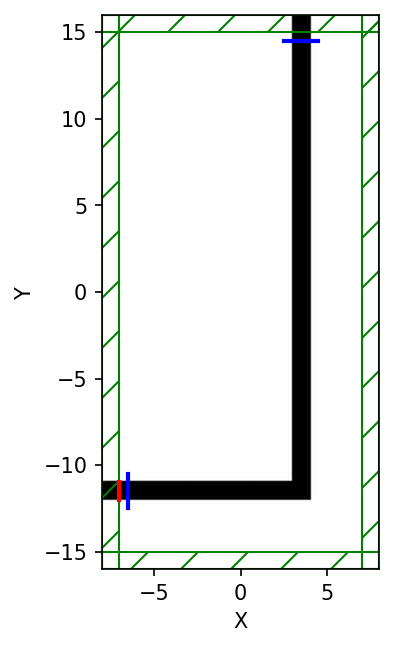

In [22]:
#now for waveguide bend portion

sim.reset_meep()

geometry = [
    mp.Block(
        mp.Vector3(sx - pad, w, mp.inf),
        center=mp.Vector3(-0.5 * pad, wvg_ycen),
        material=mp.Medium(epsilon=12),
    ),
    mp.Block(
        mp.Vector3(w, sy - pad, mp.inf),
        center = mp.Vector3(wvg_xcen, 0.5 * pad),
        material = mp.Medium(epsilon=12),
    ),
]

sim = mp.Simulation(
    cell_size = cell,
    boundary_layers=pml_layers,
    geometry = geometry,
    sources = sources,
    resolution = resolution,
)

#reflected flux
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

tran_fr = mp.FluxRegion(
    center=mp.Vector3(wvg_xcen, 0.5 * sy - dpml - 0.5, 0), size = mp.Vector3(2 * w, 0, 0)
)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

#for a normal run, load negated fields to subtract incident from refl. fields
sim.load_minus_flux_data(refl, straight_refl_data)

pt = mp.Vector3(wvg_xcen, 0.5 * sy - dpml - 0.5)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-3))

bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)

plt.figure(dpi=150)
sim.plot2D()
plt.show()

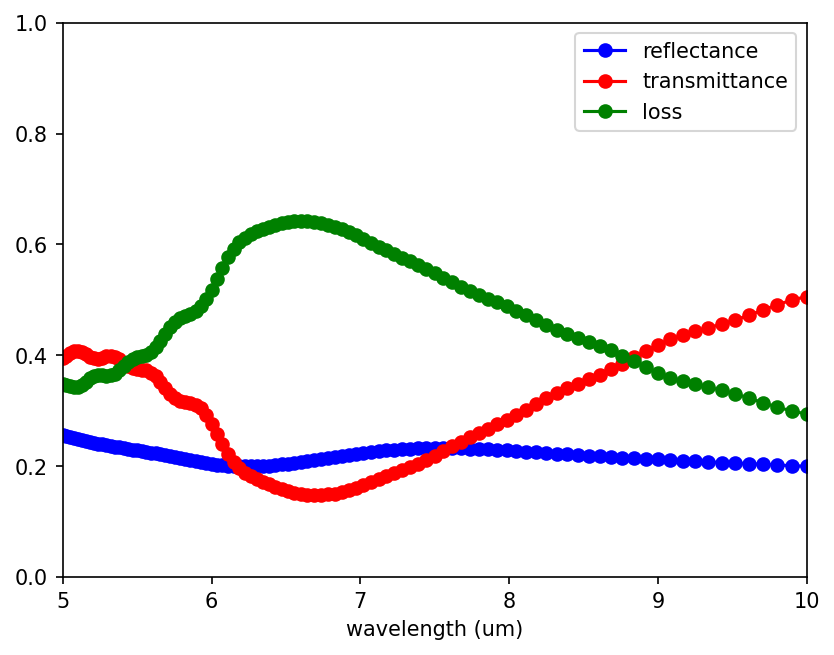

In [23]:
#now we have all the data

#i will compute and plot reflectance and transmittance.

wl = []
Rs = []
Ts = []

for i in range(nfreq):
    wl = np.append(wl, 1 / flux_freqs[i])

    #reflectance is reflected flux divided by incident flux
    #mulitply by - 1 because fluxes in Meep are done in positive direction by default, but i want -x direction
    Rs = np.append(Rs, -bend_refl_flux[i] / straight_tran_flux[i])

    #transmittance is transmitted flux divided by incident flux.
    Ts = np.append(Ts, bend_tran_flux[i] / straight_tran_flux[i])

    #scattered loss is 1 - transmittance - relfectance.

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Rs, "bo-", label = "reflectance")
    plt.plot(wl, Ts, "ro-", label = "transmittance")
    plt.plot(wl, 1 - Rs - Ts, "go-", label = "loss")
    plt.axis([5.0, 10.0, 0, 1])
    plt.xlabel("wavelength (um)")
    plt.legend(loc = "upper right")
    plt.show()

    